# Plotting Examples

In this notebook, we demonstrate how to write a simple [`Model`](http://python-qinfer.readthedocs.org/en/latest/apiref/abstract_models.html#qinfer.abstract_model.Model), run an SMC updater for several experiments, then plot the resulting posterior distribution.

## Preamble

Before anything else, it's helpful to take care of some boiler plate. First, we want to enable pylab inline mode so that the plots will be associated with this notebook.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
try: plt.style.use('ggplot')
except: pass

Next, it's a good idea in any Python 2.x program to turn on the `division` feature. This ensures that the `/` operator always returns a `float` if its arguments are numeric.

In [2]:
from __future__ import division, print_function

Having set things up, we can now import the parts of **QInfer** that we will be using in this example.

In [3]:
from qinfer.abstract_model import FiniteOutcomeModel, Model
from qinfer.distributions import UniformDistribution
from qinfer.smc import SMCUpdater
import scipy.stats

## Model Definition

For this example, we'll be using a very simple likelihood function,
$$
    \Pr(0 | \omega_1, \omega_2; t_1, t_2) = \cos^2(\omega_1 t_1) \cos^2(\omega_2 t_2).
$$
The model parameters for this function are $\vec{x} = (\omega_1, \omega_2)$, and the experimental
parameters are $\vec{e} = (t_1, t_2)$.

This likelihood function demonstrates many of the core concepts we want to explore here, but is simple enough to implement quickly.

In [9]:
# We start off by making a new class that inherits from Model.
class MultiCosModel(FiniteOutcomeModel):
    
    # We need to specify how many model parameters this model has.
    @property
    def n_modelparams(self):
        return 2
    
    # The number of outcomes is always 2, so we indicate that it's constant
    # and define the n_outcomes method to return that constant.
    @property
    def is_n_outcomes_constant(self):
        return True
    def n_outcomes(self, expparams):
        return 2
    
    # Next, we denote that the experiment parameters are represented by a
    # single field of two floats.
    @property
    def expparams_dtype(self):
        return [('ts', '2float')]
    
    # Valid models are defined to lie in the range [0, 1].
    def are_models_valid(self, modelparams):
        return np.all(np.logical_and(modelparams > 0, modelparams <= 1), axis=1)
    
    # Finally, the likelihood function itself.
    def likelihood(self, outcomes, modelparams, expparams):
        # We first call the superclass method, which basically
        # just makes sure that call count diagnostics are properly
        # logged.
        super(MultiCosModel, self).likelihood(outcomes, modelparams, expparams)
        
        # Next, since we have a two-outcome model, everything is defined by
        # Pr(0 | modelparams; expparams), so we find the probability of 0
        # for each model and each experiment.
        #
        # We do so by taking a product along the modelparam index (len 2,
        # indicating omega_1 or omega_2), then squaring the result.
        pr0 = np.prod(
            np.cos(
                # shape (n_models, 1, 2)
                modelparams[:, np.newaxis, :] *
                # shape (n_experiments, 2)
                expparams['ts']
            ), # <- broadcasts to shape (n_models, n_experiments, 2).
            axis=2 # <- product over the final index (len 2)
        ) ** 2 # square each element
        
        # Now we use pr0_to_likelihood_array to turn this two index array
        # above into the form expected by SMCUpdater and other consumers
        # of likelihood().
        return FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, pr0)

Now that we've defined a model, we can make an instance.

In [10]:
m = MultiCosModel()

The prior we take to be $\pi(\omega_1, \omega_2) = 1$ for all $\omega_i \in [0, 1]$.

In [11]:
prior = UniformDistribution([[0, 1], [0, 1]])

Finally, we can pass the model and the prior to the updater. We will use 2500 particles.

In [12]:
updater = SMCUpdater(m, 2500, prior)

Let's run a few experiments.

In [13]:
true = prior.sample()
for idx_exp in range(50):
    # Use the variance in the posterior to set the time we evolve for.
    # Note that this is a slight generalization of the
    # particle guess heuristic introduced in [].
    #
    # We slow it down by 30% to ensure unimodality, since we
    # don't have an inversion argument here.
    expparams = np.array([
        # We want one element...
        (
             # ...containing an array.
             0.7 / (2 * np.pi * np.diag(scipy.linalg.sqrtm(updater.est_covariance_mtx()))),
        )
    ], dtype=m.expparams_dtype)
    
    o = m.simulate_experiment(true, expparams)
    
    updater.update(o, expparams)

Using the [`plot_posterior_contour`](http://python-qinfer.readthedocs.org/en/latest/apiref/smc.html#qinfer.smc.SMCUpdater.plot_posterior_contour) method of `SMCUpdater`, we can quickly produce a contour plot of the current posterior distribution.

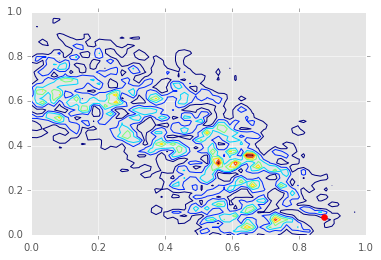

In [14]:
updater.plot_posterior_contour(res1=60, res2=60)
plt.plot(true[0, 0], true[0, 1], 'r.', markersize=12)

Using [`posterior_mesh`](http://python-qinfer.readthedocs.org/en/latest/apiref/smc.html#qinfer.smc.SMCUpdater.posterior_mesh), we can also get to the raw mesh of kernel density estimated points and feed it to other plotting functions, such as [`imshow`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow).

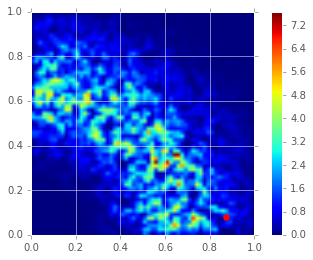

In [15]:
w1s, w2s, Z = updater.posterior_mesh(res1=60, res2=60)
plt.imshow(Z, origin='lower', extent=[np.min(w1s), np.max(w1s), np.min(w2s), np.max(w2s)])
plt.colorbar()
plt.plot(true[0, 0], true[0, 1], 'r.', markersize=12)